# The Storm-Relative Hodograph 
Creator: Cameron J. Nixon

In [1]:
# Imports software
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib.colors as cm
from matplotlib.colors import LinearSegmentedColormap, to_rgba
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from datetime import datetime, timedelta
from netCDF4 import num2date
from siphon.ncss import NCSS
from siphon.catalog import TDSCatalog
from scipy import interpolate
import metpy.calc as mpcalc
from metpy.units import units
import metpy.plots as mpplots
from metpy.plots import ctables, Hodograph

In [2]:
# Choose method
method = 'reanalysis'
# method = 'realtime'

if (method == 'reanalysis'):
    # Choose date
    year  = '2011'
    month = '04'
    day   = '27'
    hour  = '2100' # 0000-2300
    fcst  = '000' # 000
    # Choose center latitude/longitude
    center_lat = 34.0
    center_lon = -87.97

elif (method == 'realtime'):
    forecast_hour = 2
    center_lat = 33
    center_lon = -99

# Choose hodograph type
hodo_type = 'Storm-Relative'
# hodo_type = 'Rotated Shear-Relative'
# hodo_type = 'Rotated Storm-Relative'
# hodo_type = 'Ground-Relative'

# Choose motion
motion = 'R'
mirror = 'no'

# Local Area
north_lat = center_lat + .5
south_lat = center_lat - .5
west_lon = center_lon - .5
east_lon = center_lon + .5

In [3]:
# Reanalysis
if (method == 'reanalysis'):
    for attempt in range(50):
        try:
            try:
                # Downloads RAP data
                try:
                    data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-rap130anl/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
                except:
                    data = NCSS('https://www.ncdc.noaa.gov/thredds/ncss/model-rap130anl-old/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
                # Initiates query
                query = data.query()
                # Subsets by data
                query.variables('MSLP_MAPS_System_Reduction_msl',
                                'Pressure_surface',
                                'Geopotential_height_isobaric',
                                'Geopotential_height_surface',
                                'Temperature_isobaric',
                                'Relative_humidity_isobaric',
                                'Temperature_height_above_ground',
                                'Relative_humidity_height_above_ground',
                                'Dewpoint_temperature_height_above_ground',
                                'Pseudo-adiabatic_potential_temperature_or_equivalent_potential_temperature_surface', 
                                'u-component_of_wind_height_above_ground', 'v-component_of_wind_height_above_ground', 
                                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 
                                'Convective_available_potential_energy_surface',
                                'Vertical_velocity_pressure_isobaric'
                                ).add_lonlat()
                # Subsets by area
                query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
                # Gets data
                data_RAP = data.get_data(query)
                    
                # Defines data
                mslp   = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'][0,:,:]/100
                mslps  = data_RAP.variables['Pressure_surface'][0,:,:]/100
                hght   = data_RAP.variables['Geopotential_height_isobaric'][0,:,:,:]
                hghts  = data_RAP.variables['Geopotential_height_surface'][0,:,:]
                tmpp   = data_RAP.variables['Temperature_isobaric'][0,:,:,:]-273.15
                relh   = data_RAP.variables['Relative_humidity_isobaric'][0,:,:,:]
                tmps   = data_RAP.variables['Temperature_height_above_ground'][0,0,:,:]
                dwps   = data_RAP.variables['Dewpoint_temperature_height_above_ground'][0,0,:,:]
                relhs  = data_RAP.variables['Relative_humidity_height_above_ground'][0,0,:,:]
                uwnd   = data_RAP.variables['u-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                vwnd   = data_RAP.variables['v-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                uwndp  = data_RAP.variables['u-component_of_wind_isobaric'][0,:,:,:]*1.94384
                vwndp  = data_RAP.variables['v-component_of_wind_isobaric'][0,:,:,:]*1.94384
                cape   = data_RAP.variables['Convective_available_potential_energy_surface'][0,:,:]
                vvelp  = data_RAP.variables['Vertical_velocity_pressure_isobaric'][0,:,:,:]
                
                # Gets name of dimension
                dtime = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[0]
                dlat = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[1]
                dlon = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[2]
                # Gets dimension data
                lat = 1000*(data_RAP.variables[dlat][:])
                lon = 1000*(data_RAP.variables[dlon][:])
                time = data_RAP.variables[dtime]
                    
                # Gets number of latitude/longitude points
                latnum = lat.shape[0]
                lonnum = lon.shape[0]
                # Set up times
                vtimes = num2date(time[:],time.units)
                
                data_RAP.close()
                
                model = 'RAP'
                gridspace = 13000 # meters
                vertlevels = 37
                    
            except:
                try:   
                    # Downloads RUC data
                    try:
                        data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-ruc130anl/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/ruc2anl_130_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
                    except:
                        data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-ruc130anl-old/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/ruc2anl_130_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
                    # Initiates query
                    query = data.query()
                    # Subsets by data
                    query.variables('MSLP_MAPS_System_Reduction_msl',
                                    'Pressure_surface',
                                    'Geopotential_height_isobaric',
                                    'Geopotential_height_surface',
                                    'Temperature_isobaric',
                                    'Relative_humidity_isobaric',
                                    'Temperature_height_above_ground',
                                    'Dewpoint_temperature_height_above_ground',
                                    'Relative_humidity_height_above_ground',
                                    'Pseudo-adiabatic_potential_temperature_or_equivalent_potential_temperature_surface', 
                                    'u-component_of_wind_height_above_ground', 'v-component_of_wind_height_above_ground', 
                                    'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 
                                    'Storm_relative_helicity_height_above_ground_layer',
                                    'Vertical_velocity_pressure_isobaric'
                                    ).add_lonlat()
                    # Subsets by area
                    query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
                    # Gets data
                    data_RUC = data.get_data(query)
                    
                    # Defines data
                    mslp   = data_RUC.variables['MSLP_MAPS_System_Reduction_msl'][0,:,:]/100
                    mslps  = data_RUC.variables['Pressure_surface'][0,:,:]/100
                    hght   = data_RUC.variables['Geopotential_height_isobaric'][0,:,:,:]
                    hghts  = data_RUC.variables['Geopotential_height_surface'][0,:,:]
                    tmpp   = data_RUC.variables['Temperature_isobaric'][0,:,:,:]-273.15
                    relh   = data_RUC.variables['Relative_humidity_isobaric'][0,:,:,:]
                    relhs  = data_RUC.variables['Relative_humidity_height_above_ground'][0,0,:,:]
                    tmps   = data_RUC.variables['Temperature_height_above_ground'][0,0,:,:]
                    dwps   = data_RUC.variables['Dewpoint_temperature_height_above_ground'][0,0,:,:]
                    uwnd   = data_RUC.variables['u-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                    vwnd   = data_RUC.variables['v-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                    uwndp  = data_RUC.variables['u-component_of_wind_isobaric'][0,:,:,:]*1.94384
                    vwndp  = data_RUC.variables['v-component_of_wind_isobaric'][0,:,:,:]*1.94384
                    cape   = data_RUC.variables['Convective_available_potential_energy_surface'][0,:,:]
                    vvelp  = data_RUC.variables['Vertical_velocity_pressure_isobaric'][0,:,:,:]
                    
                    # Gets name of dimension
                    dtime = data_RUC.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[0]
                    dlat = data_RUC.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[1]
                    dlon = data_RUC.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[2]
                    # Gets dimension data
                    lat = 1000*(data_RUC.variables[dlat][:])
                    lon = 1000*(data_RUC.variables[dlon][:])
                    time = data_RUC.variables[dtime]
                    
                    # Gets number of latitude/longitude points
                    latnum = lat.shape[0]
                    lonnum = lon.shape[0]
                    # Set up times
                    vtimes = num2date(time[:],time.units)
                    
                    data_RUC.close()
                    
                    model = 'RUC'
                    gridspace = 13000 # meters
                    vertlevels = 37
                
                except:
                    try:
                        # Downloads RAP data
                        try:
                            data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-rap252anl/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_252_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
                        except:
                            data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-rap252anl-old/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_252_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
                        # Initiates query
                        query = data.query()
                        # Subsets by data
                        query.variables('MSLP_MAPS_System_Reduction_msl',
                                        'Pressure_surface',
                                        'Geopotential_height_isobaric',
                                        'Geopotential_height_surface',
                                        'Temperature_isobaric',
                                        'Relative_humidity_isobaric',
                                        'Temperature_height_above_ground',
                                        'Dewpoint_temperature_height_above_ground',
                                        'Relative_humidity_height_above_ground',
                                        'Pseudo-adiabatic_potential_temperature_or_equivalent_potential_temperature_surface', 
                                        'u-component_of_wind_height_above_ground', 'v-component_of_wind_height_above_ground', 
                                        'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 
                                        'Convective_available_potential_energy_surface',
                                        'Vertical_velocity_pressure_isobaric'
                                        ).add_lonlat()
                        # Subsets by area
                        query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
                        # Gets data
                        data_RAP = data.get_data(query)
                        
                        # Defines data
                        mslp   = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'][0,:,:]/100
                        mslps  = data_RAP.variables['Pressure_surface'][0,:,:]/100
                        hght   = data_RAP.variables['Geopotential_height_isobaric'][0,:,:,:]
                        hghts  = data_RAP.variables['Geopotential_height_surface'][0,:,:]
                        tmpp   = data_RAP.variables['Temperature_isobaric'][0,:,:,:]-273.15
                        relh   = data_RAP.variables['Relative_humidity_isobaric'][0,:,:,:]
                        tmps   = data_RAP.variables['Temperature_height_above_ground'][0,0,:,:]
                        dwps   = data_RAP.variables['Dewpoint_temperature_height_above_ground'][0,0,:,:]
                        relhs   = data_RAP.variables['Relative_humidity_height_above_ground'][0,0,:,:]
                        uwnd   = data_RAP.variables['u-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                        vwnd   = data_RAP.variables['v-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                        uwndp  = data_RAP.variables['u-component_of_wind_isobaric'][0,:,:,:]*1.94384
                        vwndp  = data_RAP.variables['v-component_of_wind_isobaric'][0,:,:,:]*1.94384
                        cape   = data_RAP.variables['Convective_available_potential_energy_surface'][0,:,:]
                        vvelp  = data_RAP.variables['Vertical_velocity_pressure_isobaric'][0,:,:,:]
                        
                        # Gets name of dimension
                        dtime = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[0]
                        dlat = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[1]
                        dlon = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[2]
                        # Gets dimension data
                        lat = 1000*(data_RAP.variables[dlat][:])
                        lon = 1000*(data_RAP.variables[dlon][:])
                        time = data_RAP.variables[dtime]
                        
                        # Gets number of latitude/longitude points
                        latnum = lat.shape[0]
                        lonnum = lon.shape[0]
                        # Set up times
                        vtimes = num2date(time[:],time.units)
                        
                        data_RAP.close()
                        
                        model = 'RAP'
                        gridspace = 20000 # meters
                        vertlevels = 37
                        
                    except:
                        # Downloads RUC data
                        try:
                            data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-ruc252anl/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/ruc2anl_252_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb')
                        except:
                            data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-ruc252anl-old/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/ruc2anl_252_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb')
                        # Initiates query
                        query = data.query()
                        # Subsets by data
                        query.variables('Mean_Sea_Level_Pressure_MAPS_System_Reduction_msl',
                                        'Pressure_surface',
                                        'Geopotential_height_isobaric',
                                        'Geopotential_height_surface',
                                        'Temperature_isobaric',
                                        'Relative_humidity_isobaric',
                                        'Temperature_height_above_ground',
                                        'Dew_point_temperature_height_above_ground',
                                        'Relative_humidity_height_above_ground',
                                        'Pseudo-adiabatic_potential_temperature_or_equivalent_potential_temperature_surface', 
                                        'u-component_of_wind_height_above_ground', 'v-component_of_wind_height_above_ground', 
                                        'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 
                                        'Convective_Available_Potential_Energy_surface',
                                        'Vertical_velocity_pressure_isobaric'
                                        ).add_lonlat()
                        # Subsets by area
                        query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
                        # Gets data
                        data_RUC = data.get_data(query)
                        
                        # Defines data
                        mslp   = data_RUC.variables['Mean_Sea_Level_Pressure_MAPS_System_Reduction_msl'][0,:,:]/100
                        mslps  = data_RUC.variables['Pressure_surface'][0,:,:]/100
                        hght   = data_RUC.variables['Geopotential_height_isobaric'][0,:,:,:]
                        hghts  = data_RUC.variables['Geopotential_height_surface'][0,:,:]
                        tmpp   = data_RUC.variables['Temperature_isobaric'][0,:,:,:]-273.15
                        relh   = data_RUC.variables['Relative_humidity_isobaric'][0,:,:,:]
                        tmps   = data_RUC.variables['Temperature_height_above_ground'][0,0,:,:]
                        relhs  = data_RUC.variables['Relative_humidity_height_above_ground'][0,0,:,:]
                        dwps   = data_RUC.variables['Dew_point_temperature_height_above_ground'][0,0,:,:]
                        uwnd   = data_RUC.variables['u-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                        vwnd   = data_RUC.variables['v-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                        uwndp  = data_RUC.variables['u-component_of_wind_isobaric'][0,:,:,:]*1.94384
                        vwndp  = data_RUC.variables['v-component_of_wind_isobaric'][0,:,:,:]*1.94384
                        cape   = data_RUC.variables['Convective_Available_Potential_Energy_surface'][0,:,:]
                        vvelp  = data_RUC.variables['Vertical_velocity_pressure_isobaric'][0,:,:,:]
                        
                        # Gets name of dimension
                        dtime = data_RUC.variables['Mean_Sea_Level_Pressure_MAPS_System_Reduction_msl'].dimensions[0]
                        dlat = data_RUC.variables['Mean_Sea_Level_Pressure_MAPS_System_Reduction_msl'].dimensions[1]
                        dlon = data_RUC.variables['Mean_Sea_Level_Pressure_MAPS_System_Reduction_msl'].dimensions[2]
                        # Gets dimension data
                        lat = 1000*(data_RUC.variables[dlat][:])
                        lon = 1000*(data_RUC.variables[dlon][:])
                        time = data_RUC.variables[dtime]
                        
                        # Gets number of latitude/longitude points
                        latnum = lat.shape[0]
                        lonnum = lon.shape[0]
                        # Set up times
                        vtimes = num2date(time[:],time.units)
                        
                        data_RUC.close()
                        
                        model = 'RUC'
                        gridspace = 20000 # meter
                        vertlevels = 37   
        except:
            print('server failure (UCAR)')
        else:
            break
    else:
        print('server down (UCAR)')
        

# Real-Time
elif (method == 'realtime'):
    # Imports Surface Heights
    for attempt in range(50):
        try:
            # Choose date (random)
            year  = '2018'
            month = '05'
            day   = '15'
            hour  = '0200' # 0000-2300
            fcst  = '000' # 000
            # Downloads RAP data
            data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-rap130anl-old/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
            # Initiates query
            query = data.query()
            # Subsets by data
            query.variables(
                            'Geopotential_height_surface'
                            ).add_lonlat()
            # Subsets by area
            query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
            # Gets data
            data_RAP = data.get_data(query)
            # Defines data
            hghts  = data_RAP.variables['Geopotential_height_surface'][0,:,:]
            data_RAP.close
        except:
            print('failed attempt')
        else:
            break
    else:
        print('failed, corrupt data')
        
    # Downloads RAP data
    cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/CONUS_13km/latest.xml')
    latest_ds = list(cat.datasets.values())[0]
    ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])
    # Initiates query
    query = ncss.query()
    # Find start time
    start_time = ncss.metadata.time_span['begin']
    start_hour = datetime.strptime(start_time, '%Y-%m-%dT%H:%M:%SZ')
    fhour = start_hour+timedelta(hours=forecast_hour)
    # Subsets by time
    query.time(fhour).accept('netcdf4')
    # Subsets by data
    query.variables('MSLP_MAPS_System_Reduction_msl',
                    'Pressure_surface',
                    'Geopotential_height_isobaric',
                    'Temperature_isobaric',
                    'Relative_humidity_isobaric',
                    'Temperature_height_above_ground',
                    'Relative_humidity_height_above_ground',
                    'u-component_of_wind_height_above_ground', 'v-component_of_wind_height_above_ground', 
                    'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric',
                    )
    # Subsets by area
    query.add_lonlat().lonlat_box(west_lon,east_lon,south_lat,north_lat)
    # Gets data
    data_RAP = ncss.get_data(query)
    
    # Defines RAP data
    mslp   = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'][0,:,:]/100
    mslps  = data_RAP.variables['Pressure_surface'][0,:,:]/100
    hght   = data_RAP.variables['Geopotential_height_isobaric'][0,:,:,:]
    tmpp   = data_RAP.variables['Temperature_isobaric'][0,:,:,:]-273.15
    relhs  = data_RAP.variables['Relative_humidity_height_above_ground'][0,0,:,:]
    relh   = data_RAP.variables['Relative_humidity_isobaric'][0,:,:,:]
    tmps   = data_RAP.variables['Temperature_height_above_ground'][0,0,:,:]
    dwps = (mpcalc.dewpoint_from_relative_humidity(np.array(tmps)*units('degK'),np.array(relhs/100)).m)+273.15
    thetae = mpcalc.equivalent_potential_temperature(np.array(mslps)*units.hPa,np.array(tmps)*units('kelvin'),np.array(dwps)*units('kelvin'))
    uwnd   = data_RAP.variables['u-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
    vwnd   = data_RAP.variables['v-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
    uwndp  = data_RAP.variables['u-component_of_wind_isobaric'][0,:,:,:]*1.94384
    vwndp  = data_RAP.variables['v-component_of_wind_isobaric'][0,:,:,:]*1.94

    # Gets name of dimension
    dtime = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[0]
    dlat = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[1]
    dlon = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[2]
    # Gets dimension data
    lat = 1000*(data_RAP.variables[dlat][:])
    lon = 1000*(data_RAP.variables[dlon][:])
    time = data_RAP.variables[dtime]
    # Gets number of latitude/longitude points
    latnum = lat.shape[0]
    lonnum = lon.shape[0]
    # Set up times
    vtimes = num2date(time[:],time.units)
    
    data_RAP.close()

    model = 'RAP'
    gridspace = 13000 # meters
    vertlevels = 37  

In [4]:
# Set up projection
crs = ccrs.PlateCarree()

# Set up array of latitude / longitude values and transform to native projection.
clons, clats = np.meshgrid(lon, lat)
tlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=-95, central_latitude=25,standard_parallels=(25.,25.),globe=ccrs.Globe(datum='WGS84',ellipse='sphere')),clons,clats)
tlons = tlatlons[:,:,0]
tlats = tlatlons[:,:,1]

# Find array index closest to location
location = (center_lon,center_lat)
# calculate distance between center lat/lon and analog cases (Haversine)
def haversine(lon_arr, lat_arr, lon_point, lat_point): 
    distance = 6371*(2*np.arcsin(np.sqrt(np.sin((np.radians(lat_arr)-np.radians(lat_point))/2)**2 + np.cos(np.radians(lat_point)) * np.cos(np.radians(lat_arr)) * np.sin((np.radians(lon_arr)-np.radians(lon_point))/2)**2)))
    return distance
location_distance = haversine(tlons,tlats,location[0],location[1])
location_index = np.where(location_distance == np.min(location_distance))

In [5]:
"""
get_sfc_index

This function takes an array of height values and finds the index before the first positive value

Input: height_arr (array-like object of height values)

Output: index (int indicating the index just before the first positive height value. If -1 is returned,
               a positive index could not be found.)
"""

def get_sfc_index(height_arr):
    
    i = 0
    
    # Search the array for the sfc index
    while i < len(height_arr):
        if height_arr[i] >= 0:
            return i
            
        else:
            i += 1
            
    # Did not find a positive index
    return -1

"""
make_sfc_based

This function takes an array and a valid index in that array, then returns a copy of the
array beginning at the provided index i.e., chops off below-ground values

Inputs: arr (array-like object)
        index (int indicating the index where copying will begin)

Output: mod_arr (numpy array with the values from arr[index:len(arr)])
"""

def make_sfc_based(arr, sfc_val, sfc_index):
    
    # Initialize an empty numpy array as the modified array
    mod_arr = np.empty(len(arr) - sfc_index)
    
    # Insert the sfc and higher values into the modified array
    i = 0
    while i < len(mod_arr):
        mod_arr[i] = arr[i + sfc_index]
        i = i + 1
    
    # Inserts surface values
    mod_arr = np.insert(mod_arr, 0, sfc_val)
    return mod_arr

# Finds Upper-level Values
p = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
p = p[::-1]
ps = mslps[location_index[0],location_index[1]][0]*units.hPa
h = hght[::-1,location_index[0],location_index[1]][:,0]-hghts[location_index[0],location_index[1]][0]
hs = hghts[location_index[0],location_index[1]][0]*units.meter
u = uwndp[::-1,location_index[0],location_index[1]][:,0]
v = vwndp[::-1,location_index[0],location_index[1]][:,0]
T = tmpp[::-1,location_index[0],location_index[1]]
Td = (243.04*(np.log(relh[:,location_index[0],location_index[1]]/100)+((17.625*tmpp[:,location_index[0],location_index[1]])/(243.04+tmpp[:,location_index[0],location_index[1]])))/(17.625-np.log(relh[:,location_index[0],location_index[1]]/100)-((17.625*tmpp[:,location_index[0],location_index[1]])/(243.04+tmpp[:,location_index[0],location_index[1]]))))
Td = Td[::-1]
RH = relh[:,location_index[0],location_index[1]]/100

# Finds Surface Values
ps = mslps[location_index[0],location_index[1]][0]
hs = 0
us = uwnd[location_index[0],location_index[1]][0]
vs = vwnd[location_index[0],location_index[1]][0]
Ts = tmps[location_index[0],location_index[1]][0]-273.15
Tds = dwps[location_index[0],location_index[1]][0]-273.15
RHs = relhs[location_index[0],location_index[1]][0]

# Creates Arrays for Vertical Profile
sfc_index = get_sfc_index(h)
h_new = make_sfc_based(h, hs, sfc_index)
p_new = make_sfc_based(p, ps, sfc_index)
u_new = make_sfc_based(u, us, sfc_index)
v_new = make_sfc_based(v, vs, sfc_index)
T_new = make_sfc_based(T, Ts, sfc_index)
Td_new = make_sfc_based(Td, Tds, sfc_index)
RH_new = make_sfc_based(RH, RHs, sfc_index)

h = h_new*units.meter
p = p_new*units.hPa
u = u_new*units.knot
v = v_new*units.knot
T = T_new*units.degC
Td = Td_new*units.degC
RH = RH_new*units.percent

d = mpcalc.wind_direction(u, v)
spd = mpcalc.wind_speed(u, v)

In [6]:
# Interpolates data
dz = 250 

# determines interpolation levels
soundingtop_hght = h[-1].m
toplvl = int(soundingtop_hght/dz)*dz
numlvls = int(toplvl/dz)
interp_lvls = np.linspace(0,toplvl,numlvls+1)

# initializes new arrays
unew = np.zeros((len(interp_lvls)))
vnew = np.zeros((len(interp_lvls)))
Tnew = np.zeros((len(interp_lvls)))
Tdnew = np.zeros((len(interp_lvls)))
RHnew = np.zeros((len(interp_lvls)))
hnew = np.zeros((len(interp_lvls)))
pnew = np.zeros((len(interp_lvls)))

unew[0] = u[0].m
vnew[0] = v[0].m
Tnew[0] = T[0].m
Tdnew[0] = Td[0].m
RHnew[0] = RH[0].m
hnew[0] = h[0].m
pnew[0] = p[0].m

# interpolates existing data
u_interp = interpolate.interp1d(h, u)
v_interp = interpolate.interp1d(h, v)
T_interp = interpolate.interp1d(h, T)
Td_interp = interpolate.interp1d(h, Td)
RH_interp = interpolate.interp1d(h, RH)
h_interp = interpolate.interp1d(h, h)
p_interp = interpolate.interp1d(h, p)

# creates arrays of interpolated data
for i in range(1,len(unew),1):
    unew[i] = u_interp(dz*i)
for i in range(1,len(vnew),1):
    vnew[i] = v_interp(dz*i)
for i in range(1,len(Tnew),1):
    Tnew[i] = T_interp(dz*i)
for i in range(1,len(Tdnew),1):
    Tdnew[i] = Td_interp(dz*i)
for i in range(1,len(RHnew),1):
    RHnew[i] = RH_interp(dz*i)
for i in range(1,len(hnew),1):
    hnew[i] = h_interp(dz*i)
for i in range(1,len(pnew),1):
    pnew[i] = p_interp(dz*i)

u = np.array(unew)*units('knot')
v = np.array(vnew)*units('knot')
T = np.array(Tnew)*units('degC')
Td = np.array(Tdnew)*units('degC')
RH = np.array(RHnew)*units('percent')
h = np.array(hnew)*units('meter')
p = np.array(pnew)*units('hPa')

d = mpcalc.wind_direction(u, v)
spd = mpcalc.wind_speed(u, v)

# Applies sfc values
try:
    if (Tsfc):
        T[0] = (Tsfc*units('degF')).to('degC')
    if (Tdsfc):
        Td[0] = (Tdsfc*units('degF')).to('degC')
    if (spdsfc):
        u[0],v[0] = mpcalc.wind_components(spdsfc*units('knot'),dirsfc*units('degrees'))
except:
    pass

# Defines significant levels
try:
    h0 = np.where(h==0.*units('meter'))[0][0]
    h05 = np.where(h==500.*units('meter'))[0][0]
    h1 = np.where(h==1000.*units('meter'))[0][0]
    h15 = np.where(h==1500.*units('meter'))[0][0]
    h2 = np.where(h==2000.*units('meter'))[0][0]
    h25 = np.where(h==2500.*units('meter'))[0][0]
    h3 = np.where(h==3000.*units('meter'))[0][0]
    h4 = np.where(h==4000.*units('meter'))[0][0]
    h5 = np.where(h==5000.*units('meter'))[0][0]
    h6 = np.where(h==6000.*units('meter'))[0][0]
    h7 = np.where(h==7000.*units('meter'))[0][0]
    h8 = np.where(h==8000.*units('meter'))[0][0]
    h9 = np.where(h==9000.*units('meter'))[0][0]
    h10 = np.where(h==10000.*units('meter'))[0][0]
    h11 = np.where(h==11000.*units('meter'))[0][0]
    h12 = np.where(h==12000.*units('meter'))[0][0]
    h13 = np.where(h==13000.*units('meter'))[0][0]
    h14 = np.where(h==14000.*units('meter'))[0][0]
    h155 = np.where(h==15000.*units('meter'))[0][0]
except:
    pass

In [7]:
# Calculates storm motions
rightmover,leftmover,meanwind = mpcalc.bunkers_storm_motion(p,u,v,h)[:]
rightmoveru = rightmover[0]
rightmoverv = rightmover[1]
leftmoveru = leftmover[0]
leftmoverv = leftmover[1]
meanwindu = meanwind[0]
meanwindv = meanwind[1]

# rightmoveru = 32*units('knot')
# rightmoverv = 0*units('knot')

# Calculates storm-relative hodographs
ur = u-rightmoveru
vr = v-rightmoverv
ul = u-leftmoveru
vl = v-leftmoverv

# Calculates rotated storm-relative hodographs
rightmoverangle = -1*((np.pi)-(np.degrees(mpcalc.wind_direction(rightmoveru,rightmoverv))))
urmsr = ur*np.cos(rightmoverangle) - vr*np.sin(rightmoverangle)
vrmsr = ur*np.sin(rightmoverangle) + vr*np.cos(rightmoverangle)
rightmoverdir = np.degrees(mpcalc.wind_direction(rightmoveru,rightmoverv))
rightmoverspd = np.sqrt(rightmoveru**2+rightmoverv**2)

In [8]:
RM_u = rightmoveru
RM_v = rightmoverv

# Defines hodograph origin / relativity
if (hodo_type == 'Rotated Shear-Relative'):
    shearu = u[h3]-u[h0]
    shearv = v[h3]-v[h0]
    shearangle = (mpcalc.wind_direction(shearu,shearv)-np.pi).m
    unew = (u*np.cos(shearangle) - v*np.sin(shearangle))
    unew = unew - unew[h0]
    vnew = (u*np.sin(shearangle) + v*np.cos(shearangle))
    vnew = vnew - vnew[h0]
elif (hodo_type == 'Rotated Storm-Relative'):
    if (motion == 'R'):
        storm_u = RM_u
        storm_v = RM_v
        if (mirror == 'yes'):
            usr = u-storm_u
            vsr = vbulk-storm_v
            stormangle = -1*((np.pi)-(np.degrees(mpcalc.wind_direction(storm_u,storm_v))))
            unew = usr*np.cos(stormangle) - vsr*np.sin(stormangle)
            vnew = usr*np.sin(stormangle) + vsr*np.cos(stormangle)
            unew = unew*-1
        elif (mirror == 'no'):
            usr = u-storm_u
            vsr = v-storm_v
            stormangle = -1*((np.pi)-(np.degrees(mpcalc.wind_direction(storm_u,storm_v))))
            unew = usr*np.cos(stormangle) - vsr*np.sin(stormangle)
            vnew = usr*np.sin(stormangle) + vsr*np.cos(stormangle)
    elif (motion == 'L'):
        storm_u = LM_u
        storm_v = LM_v
        stormangle = np.zeros(len(u))
        if (mirror == 'yes'):
            usr = u-storm_u
            vsr = v-storm_v
            stormangle = -1*((np.pi)-(np.degrees(mpcalc.wind_direction(storm_u,storm_v))))
            unew = usr*np.cos(stormangle) - vsr*np.sin(stormangle)
            vnew = usr*np.sin(stormangle) + vsr*np.cos(stormangle)
            unew = unew*-1
        elif (mirror == 'no'):
            usr = u-storm_u
            vsr = v-storm_v
            stormangle = -1*((np.pi)-(np.degrees(mpcalc.wind_direction(storm_u,storm_v))))
            unew = usr*np.cos(stormangle) - vsr*np.sin(stormangle)
            vnew = usr*np.sin(stormangle) + vsr*np.cos(stormangle)  
elif (hodo_type == 'Storm-Relative'):
    if (motion == 'R'):
        storm_u = RM_u
        storm_v = RM_v
        unew = u-RM_u
        vnew = v-RM_v    
    elif (motion == 'L'):
        storm_u = LM_u
        storm_v = LM_v
        unew = u-LM_u
        vnew = v-LM_v
else:
    unew = u
    vnew = v
                
ur = unew
vr = vnew

Text(0.01, 0.972, 'RUC 21Z F00 | VALID: 2011-04-27 2100Z | 34.0,-87.97')

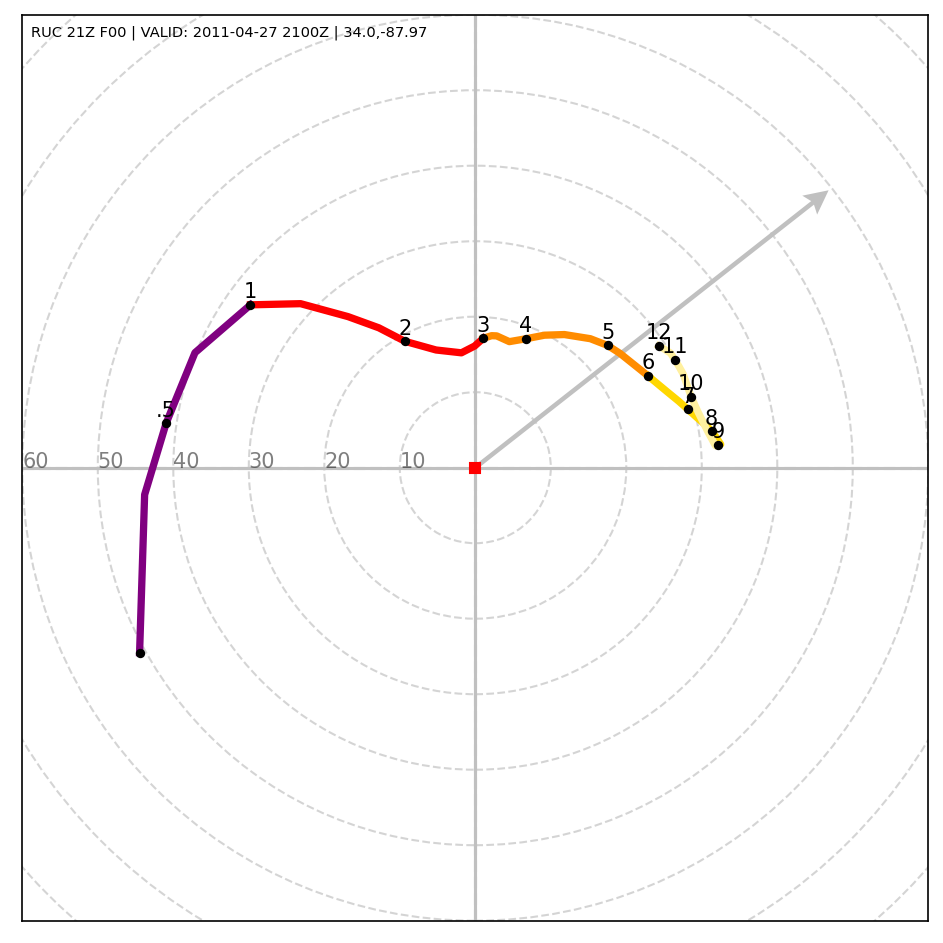

In [9]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = plt.subplot()
fig.patch.set_facecolor('white')

# Choose hodograph colors
hodo_color = ['purple','red','darkorange','gold','#fff09f']

# Create a hodograph
if (hodo_type == 'Rotated Shear-Relative'):
    [ur,vr] = [vr,-ur]
    hod = mpplots.Hodograph(ax, component_range=100)
    hod.add_grid(increment=10,color='silver',alpha=0.67,zorder=0)
    ax.set_xlim(-75,75)
    ax.set_ylim(-75,75)
    ax.plot([-200,200],[0,0],color='silver',linestyle='-',linewidth=1.5,clip_on=True,alpha=1,zorder=0)
    ax.plot([0,0],[-200,200],color='silver',linestyle='-',linewidth=1.5,clip_on=True,alpha=1,zorder=0)
    # Plots tick marks inside the hodograph
    plt.xticks(np.arange(0,0,1))
    plt.yticks(np.arange(0,0,1))
    for i in range(10,80,10):
        plt.text(0,i,str(i),verticalalignment='bottom',horizontalalignment='left',fontsize=8,alpha=1,color='grey',clip_on=True)
        
elif (hodo_type == 'Ground-Relative'):
    hod = mpplots.Hodograph(ax, component_range=100)
    hod.add_grid(increment=10,color='silver',alpha=0.67,zorder=0)
    ax.set_xlim(-65,65)
    ax.set_ylim(-65,65)
    ax.plot([-200,200],[0,0],color='silver',linestyle='-',linewidth=1.5,clip_on=True,alpha=1,zorder=0)
    ax.plot([0,0],[-200,200],color='silver',linestyle='-',linewidth=1.5,clip_on=True,alpha=1,zorder=0)
    # Plots tick marks inside the hodograph
    plt.xticks(np.arange(0,0,1))
    plt.yticks(np.arange(0,0,1))
    for i in range(10,70,10):
        plt.text(0,i,str(i),verticalalignment='bottom',horizontalalignment='left',fontsize=8,alpha=1,color='grey',clip_on=True)
else:
    hod = mpplots.Hodograph(ax, component_range=100)
    hod.add_grid(increment=10,color='silver',alpha=0.67,zorder=0)
    ax.set_xlim(-60,60)
    ax.set_ylim(-60,60)
    ax.plot([-200,200],[0,0],color='silver',linestyle='-',linewidth=1.5,clip_on=True,alpha=1,zorder=0)
    ax.plot([0,0],[-200,200],color='silver',linestyle='-',linewidth=1.5,clip_on=True,alpha=1,zorder=0)
    # Plots tick marks inside the hodograph
    plt.xticks(np.arange(0,0,1))
    plt.yticks(np.arange(0,0,1))
    for i in range(10,70,10):
        ax.annotate(str(i),(0-i,0),xytext=(0,0),textcoords='offset pixels',clip_on=True,alpha=0.5,zorder=0)

# Plots storm motion
if (hodo_type == 'Storm-Relative'):
    hod.plot(0,0, color='red',marker='s',markersize=5,zorder=5,clip_on=True)
    ax.quiver(0,0,rightmoveru.m,rightmoverv.m,color='silver',angles='xy', scale_units='xy', scale=1,headwidth=5.3,headlength=5.3,width=.005,zorder=1,clip_on=True)
elif (hodo_type == 'Rotated Storm-Relative'):
    hod.plot(0,0, color='red',marker='s',markersize=5,zorder=5,clip_on=True)
    ax.quiver(0,0,0,rightmoverspd.m,color='silver',angles='xy', scale_units='xy', scale=1,headwidth=5.3,headlength=5.3,width=.005,zorder=1,clip_on=True)
elif (hodo_type == 'Ground-Relative'):
    hod.plot(rightmoveru.m,rightmoverv.m, color='red',marker='s',markersize=5,zorder=5,clip_on=True)
    hod.plot(rightmover[0].m,rightmover[1].m,color='red',marker='s',markersize=5,zorder=5,clip_on=True)
    ax.annotate('RM',(rightmoveru,rightmoverv),xytext=(0,-25),textcoords='offset pixels',horizontalalignment='center',clip_on=True,color='red')
#     hod.plot((rightmoveru.m+np.mean(ur[0:h1].m+1))/2,(rightmoverv.m+np.mean(vr[0:h1].m+1))/2,color='magenta',marker='s',markersize=5,zorder=5)
#     ax.annotate('DTM',((rightmoveru.m+np.mean(ur[0:h1].m+1))/2,(rightmoverv.m+np.mean(vr[0:h1].m+1))/2),xytext=(0,-25),textcoords='offset pixels',horizontalalignment='center',clip_on=True,color='magenta')
    hod.plot(meanwindu.m,meanwindv.m, color='grey',marker='s',markersize=5,zorder=5)

# Plots hodograph
ax.plot(ur[0:h1+1].m, vr[0:h1+1].m, color=hodo_color[0], linewidth=3.5,clip_on=True)
ax.plot(ur[h1:h3+1].m, vr[h1:h3+1].m, color=hodo_color[1], linewidth=3.5,clip_on=True)
ax.plot(ur[h3:h6+1].m, vr[h3:h6+1].m, color=hodo_color[2], linewidth=3.5,clip_on=True)
ax.plot(ur[h6:h9+1].m, vr[h6:h9+1].m, color=hodo_color[3], linewidth=3.5,clip_on=True)
ax.plot(ur[h9:h12+1].m, vr[h9:h12+1].m, color=hodo_color[4], linewidth=3.5,clip_on=True)
    
# Hodograph height labels
hod.plot(ur[h05],vr[h05],color='black',marker='o',markersize=3.5,clip_on=True)
for i in (h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12):
    hod.plot(ur[i],vr[i],color='black',marker='o',markersize=3.5,clip_on=True)
ax.annotate(str('.5'),(ur[h05],vr[h05]),xytext=(0,7),textcoords='offset pixels',horizontalalignment='center',clip_on=True)
for i in (h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12):
    ax.annotate(str(int(round(h[i].m/1000,0))),(ur[i],vr[i]),xytext=(0,7),textcoords='offset pixels',horizontalalignment='center',clip_on=True) 

# Title
# plt.title(str(model)+' '+str(hour[0:2])+'Z F'+str(fcst[0:2])+' | VALID: ' +(vtimes[0].strftime('%Y'))+'-'+(vtimes[0].strftime('%m'))+'-'+(vtimes[0].strftime('%d'))+' '+(vtimes[0].strftime('%H00'))+'Z'+' | '+str(location[1])+','+str(location[0]), loc='left',fontsize=10)

if (hodo_type == 'Rotated Storm-Relative'):
    # INSET HODOGRAPH
    ax_hod = inset_axes(ax, '20%', '20%', loc='upper left')
    hod = Hodograph(ax_hod, component_range=70.)
    hod.add_grid(increment=10,color='silver',zorder=0,linewidth=0.5,alpha=0.5)

    hod.plot(u[0:h1+1].m, v[0:h1+1].m, color=hodo_color[0], linewidth=1.5,clip_on=True)
    hod.plot(u[h1:h3+1].m, v[h1:h3+1].m, color=hodo_color[1], linewidth=1.5,clip_on=True)
    hod.plot(u[h3:h6+1].m, v[h3:h6+1].m, color=hodo_color[2], linewidth=1.5,clip_on=True)
    hod.plot(u[h6:h9+1].m, v[h6:h9+1].m, color=hodo_color[3], linewidth=1.5,clip_on=True)
    hod.plot(u[h9:h12+1].m, v[h9:h12+1].m, color=hodo_color[4], linewidth=1.5,clip_on=True)

    hod.plot(rightmoveru.m,rightmoverv.m, color='red',marker='s',markersize=1.25,zorder=5,clip_on=True)
    hod.plot(leftmoveru.m,leftmoverv.m, color='dodgerblue',marker='s',markersize=1.25,zorder=5,clip_on=True)
    hod.plot(meanwindu.m,meanwindv.m, color='grey',marker='s',markersize=1.25,zorder=5,clip_on=True)
    
    ax_hod.xaxis.set_visible(False)
    ax_hod.yaxis.set_visible(False)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# Titles
ax.text(.01,.972, str(model)+' '+str(hour[0:2])+'Z F'+str(fcst[0:2])+' | VALID: ' +(vtimes[0].strftime('%Y'))+'-'+(vtimes[0].strftime('%m'))+'-'+(vtimes[0].strftime('%d'))+' '+(vtimes[0].strftime('%H00'))+'Z'+' | '+str(location[1])+','+str(location[0]),verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,fontsize=7)
# ax.text(.992,.97, str(hodo_type)+' Hodograph',verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes)